With the first part, we've used part of a previous effort that helps us visualize what words are popular.
Next, we're building on that by showing a way how to use a model that looks what words are similar to popular words in the songs using their vectors.
Lastly, we'll try and create a model that looks if it's possible to predict a year using lyrics and play with hyperparameters


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeannothennissen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding='latin-1')
data.head()

Rank                                      Song  \
0     1                               wooly bully   
1     2  i cant help myself sugar pie honey bunch   
2     3                i cant get no satisfaction   
3     4                       you were on my mind   
4     5              youve lost that lovin feelin   

                          Artist  Year  \
0  sam the sham and the pharaohs  1965   
1                      four tops  1965   
2             the rolling stones  1965   
3                        we five  1965   
4         the righteous brothers  1965   

                                              Lyrics  Source  
0  sam the sham miscellaneous wooly bully wooly b...     3.0  
1   sugar pie honey bunch you know that i love yo...     1.0  
2                                                        1.0  
3   when i woke up this morning you were on my mi...     1.0  
4   you never close your eyes anymore when i kiss...     1.0

The following code deleted duplicates

In [3]:
def remove_duplicates(table):
    df = pd.DataFrame()
    for group, tab in table.groupby(['Song','Lyrics']):
        df = df.append(tab.sort_values('Rank').iloc[0], ignore_index=True)
    return df
data = remove_duplicates(data)

using nltk stemmer to create lemmatized versions to be used for the model

In [5]:
import csv
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import TaggedDocument

wnl = WordNetLemmatizer()

class Sentences(object):
    
    def __init__(self, filename, column):
        self.filename = filename
        self.column = column
        
    def get_tokens(text):
        return [wnl.lemmatize(r.lower()) for r in text.split()]
 
    def __iter__(self):
        reader = csv.DictReader(open(self.filename, 'r' ))
        for row in reader:
            words = self.get_tokens(row[self.column])
            tags = ['%s' % (row['Artist'])]
            yield TaggedDocument(words=words, tags=tags)

In [6]:
filename = 'top10-songs-training.csv'
sentences = Sentences(filename=filename, column='Lyrics')

df_train = pd.read_csv(filename)


Having used the top10 songs for time-saving constraints as the full dataset was heavy on our computers, we create the model

In [7]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(
    alpha=0.025,
    min_alpha=0.025,
    workers=15, 
    min_count=2,
    window=10,
    size=300,
    iter=20,
    sample=0.001,
    negative=5
)



/Users/jeannothennissen/opt/anaconda3/lib/python3.9/site-packages/gensim/models/doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/jeannothennissen/opt/anaconda3/lib/python3.9/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Building the model with 10 epochs


In [8]:
model.build_vocab(sentences)
epochs = 10
for epoch in range(epochs):
    model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay



/var/folders/xv/y7x8h9tn2ll99t9yl4l6n3nh0000gn/T/ipykernel_2584/752203288.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)


In [9]:
model.save('decade-lyrics.doc2vec')

model = Doc2Vec.load('decade-lyrics.doc2vec')



In [10]:
## VECTORIZING SONG LYRICS
vectorizer = tfidf(max_features=5000, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(list(data['Lyrics']))
data = pd.concat([pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names()),data],axis=1)

/Users/jeannothennissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
## VECTORIZING SONG TITLES
vectorizer = tfidf(max_features=1000,stop_words = stopwords.words('english'))
Y = vectorizer.fit_transform(list(data['Song']))
data = pd.concat([pd.DataFrame(Y.todense(), columns=vectorizer.get_feature_names()),data],axis=1)

In [12]:
rank1 = data.drop(['Year','Rank'], axis=1).groupby(data['Rank']).sum().loc[1].sort_values(ascending=False).iloc[:10]


Text(0, 0.5, 'tf-idf weighting')

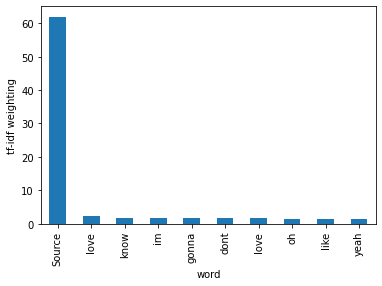

In [13]:
ax = rank1.plot(kind='bar')
ax.set_xlabel("word")
ax.set_ylabel("tf-idf weighting")

In [14]:
model.wv.word_vec('love')

array([ 1.2338153 ,  0.37265486, -0.23080212,  0.45243222, -1.0593275 ,
       -0.4989921 , -0.93947715, -0.41867554, -0.24205501,  0.2569013 ,
       -0.28349906, -0.06356327,  0.39485332,  0.09096634, -1.1964903 ,
       -0.6938308 ,  0.46122468, -0.5743462 ,  0.85904974, -1.7851167 ,
       -0.3171846 ,  0.29449293, -0.55587053,  0.36002654, -0.75061995,
        0.13852775, -1.1022084 ,  0.3191659 , -0.5400709 , -0.00423446,
        0.29729342,  0.60091275,  0.02002203,  0.39213222,  0.82126373,
        0.0422079 ,  0.14499944,  0.17651576,  0.05516843,  1.6084107 ,
        0.6232116 , -0.5217003 ,  0.12632234, -0.45143318,  0.28485802,
       -0.25312197,  0.70030403, -0.18621898,  0.5483239 , -0.70951045,
       -0.3768496 , -0.05450374,  0.50387484,  0.3681952 , -0.6848701 ,
        0.23210892,  0.63090295, -0.09790957,  0.73235273, -0.00663202,
       -0.76428294,  0.62125367,  0.12330501, -0.27807182, -0.52452135,
        0.1384321 ,  0.0875487 ,  0.65492916, -0.5322149 , -0.98

The most populair word is love, this shows what is most similar


In [15]:
model.wv.most_similar('love')

[('together', 0.24174192547798157),
 ('inside', 0.24150070548057556),
 ('sexy', 0.22229667007923126),
 ('playin', 0.20331496000289917),
 ('knew', 0.20121853053569794),
 ('arm', 0.1966618150472641),
 ('rolling', 0.19467675685882568),
 ('mate', 0.19242458045482635),
 ('body', 0.184599369764328),
 ('loveoh', 0.18384194374084473)]

Shows the word most similar to love from a given list

In [16]:
model.wv.most_similar_to_given(
    'love', 
    ['playin', 'arm', 'knew', 'apart', 'eye', 'feelyoung', 'caress']
)


'playin'

This shows what word is most similar to love if eye contributes negatively to the similarity score. Playing around with this gives a feel at how the model looks at the words.

In [17]:
model.wv.most_similar(
    positive=[model['love']],
    negative=[model['eye']]
)

[('tiger', 0.25915008783340454),
 ('love', 0.2554444670677185),
 ('apart', 0.24010935425758362),
 ('have', 0.23846957087516785),
 ('my', 0.23364809155464172),
 ('watching', 0.21344244480133057),
 ('into', 0.20971858501434326),
 ('from', 0.2055034637451172),
 ('since', 0.18755677342414856),
 ('punk', 0.18734034895896912)]

Next we're going to try and create a model which looks at the genre

In [18]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords

filename = 'top10-songs-training.csv'
train_df = pd.read_csv(filename)

filename2 = 'bill_board_test.csv'
test_df = pd.read_csv(filename2)




In [19]:
train_df.columns  

Index(['Rank', 'Song', 'Artist', 'Year', 'Lyrics', 'Source'], dtype='object')

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline



text_clf = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB(alpha=0.1))])

# train our model on training data

text_clf.fit(test_df.Lyrics.fillna(' '), test_df.Year.fillna(' '))  
predicted = text_clf.predict(test_df.Lyrics.fillna(' '))

np.mean(predicted == test_df.Year.fillna(' '))


0.9667318982387475

This is a surprisingly high score!

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

'Using TfidfVectorizer to see if we can improve the score even more'
text_clf = Pipeline(

    [('vect', TfidfVectorizer()),

     ('clf', MultinomialNB(alpha=0.1))])



text_clf.fit(test_df.Lyrics.fillna(' '), test_df.Year.fillna(' '))  
predicted = text_clf.predict(test_df.Lyrics.fillna(' '))

np.mean(predicted == test_df.Year.fillna(' '))

0.9315068493150684

The score got worse! 

In [28]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer

' using a lemmatizer and checking for n-grams, bi-grams and stopwords'

stop = list(set(stopwords.words('english'))) # stopwords

wnl = WordNetLemmatizer() # lemmatizer



def tokenizer(x): 
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) == 2 and w.isalnum())



text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer, stop_words=stop,max_df=0.4, min_df=4)), 

     ('tfidf', TfidfTransformer()),

     ('clf', MultinomialNB(alpha=0.1))])

text_clf.fit(test_df.Lyrics.fillna(' '), test_df.Year.fillna(' '))  
predicted = text_clf.predict(test_df.Lyrics.fillna(' '))

np.mean(predicted == test_df.Year.fillna(' '))



/Users/jeannothennissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wo'] not in stop_words.
  warnings.warn(


0.3913894324853229

This turned out much worse! Lets change the hyperparameters

In [24]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer



stop = list(set(stopwords.words('english'))) # stopwords

wnl = WordNetLemmatizer() # lemmatizer



def tokenizer(x): 
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) == 2 and w.isalnum())



text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(2, 8), tokenizer=tokenizer, stop_words=stop,max_df=0.01, min_df=3)), 

     ('tfidf', TfidfTransformer()),

     ('clf', MultinomialNB(alpha=0.1))])

text_clf.fit(test_df.Lyrics.fillna(' '), test_df.Year.fillna(' '))  
predicted = text_clf.predict(test_df.Lyrics.fillna(' '))

np.mean(predicted == test_df.Year.fillna(' '))



/Users/jeannothennissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wo'] not in stop_words.
  warnings.warn(


0.5675146771037182

This makes it a lot better, especially due to the n-gram increase. Still, this is worse than the original performance. Tweaking these could increase or decrease the performance further

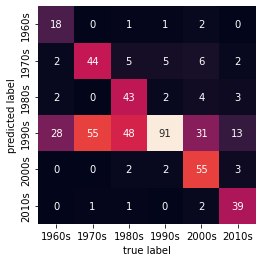

In [25]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test_df.Year, predicted)

years = ['1960s','1970s','1980s','1990s','2000s','2010s']

sns.heatmap(

    mat.T, square=True, annot=True, fmt='d', cbar=False,

    xticklabels=years, 

    yticklabels=years

)

plt.xlabel('true label')

plt.ylabel('predicted label');


In [26]:
from sklearn.metrics import precision_recall_fscore_support



precision, recall, fscore, support = precision_recall_fscore_support(test_df.Year, predicted)



for n,year in enumerate(years):

    Year = year.upper()

    print(Year+'_precision: {}'.format(precision[n]))

    print(Year+'_recall: {}'.format(recall[n]))

    print(Year+'_fscore: {}'.format(fscore[n]))

    print(Year+'_support: {}'.format(support[n]))

    print()

1960S_precision: 0.8181818181818182
1960S_recall: 0.36
1960S_fscore: 0.5
1960S_support: 50

1970S_precision: 0.6875
1970S_recall: 0.44
1970S_fscore: 0.5365853658536586
1970S_support: 100

1980S_precision: 0.7962962962962963
1980S_recall: 0.43
1980S_fscore: 0.5584415584415584
1980S_support: 100

1990S_precision: 0.34210526315789475
1990S_recall: 0.900990099009901
1990S_fscore: 0.49591280653950953
1990S_support: 101

2000S_precision: 0.8870967741935484
2000S_recall: 0.55
2000S_fscore: 0.6790123456790124
2000S_support: 100

2010S_precision: 0.9069767441860465
2010S_recall: 0.65
2010S_fscore: 0.7572815533980582
2010S_support: 60



Different decades show a lot of differences in precision and recall, probably due to word similarity. Some datasets are smaller than others such as 1960s and 2010s. Surprsinly the 1990s do very poorly at precision, perhaps they share a lot of the same lyrics in that decade and its hard to keep them apart